# Análise de dados: Falsificação de cédulas de Real (R$)

Neste projeto serão analisados os dados de falsificação de cédulas de Real (R$) com base nos dados informações (.csv) do período entre 1995 e 2020 acessíveis no portal de [Dados Abertos](https://dadosabertos.bcb.gov.br/) disponibilizados pelo [Banco Central do Brasil](https://www.bcb.gov.br/).

## Demanda da análise

- Demonstrar a evolução das falsificações
- Identificar as cédulas mais falsificadas
- Identificar os estados com mais incidência de falsificações
- Estimar para os próximos anos a incidência de falsificações

## Indagações a serem respondidas pela análise exploratória dos dados

1. Qual o total de falsificações por ano (1995 a 2020)?
2. Qual o total de falsificações por cédula e por ano (1995 a 2020)?
3. Qual o total de falsificações por estado no período de 1995 a 2020?
4. Quais os 5 estados líderes de falsificações por ano (2015 a 2020)?
5. Qual a estimativa do total de falsificações por ano (2021 e 2022)?
6. Qual a estimativa do total de falsificações por cédula e por ano (2021 e 2022)?
7. Qual a estimativa do total de falsificações por estado no período de 2021 e 2022?

## Importação de pacotes

In [42]:
# Importação de pacotes e definição de parâmetros globais

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mp
import seaborn as sns

sns.set_style('darkgrid')

## Carregamento dos dados

In [43]:
# Criando um dataframe atribuindo o arquivo csv no diretório dados e definindo o nome das colunas

df = pd.read_csv('dados/Falsificacao_DadosAbertos.csv', sep=';', header=None)

df.columns = ['Ano', 'Estado', 'Família', 'Denominação', 'Quantidade']


## Detalhes do dataframe

In [44]:
# Amostra de dados do dataframe

df.sample(10)

,Ano,Estado,Família,Denominação,Quantidade
4465,2018,GOIÁS,Cédulas - 2a. família,10.0,"574,00"
2769,2012,SÃO PAULO,Cédulas - 2a. família,100.0,"54.139,00"
4901,2019,PIAUÍ,Cédulas - 1a. família,100.0,"21,00"
2840,2013,BAHIA,Cédulas - 2a. família,20.0,"1.360,00"
1215,2005,RIO GRANDE DO NORTE,Cédulas - 1a. família,5.0,"220,00"
1439,2006,RONDÔNIA,Cédulas - 1a. família,50.0,"1.867,00"
3724,2015,TOCANTINS,Cédulas - 1a. família,50.0,"110,00"
1930,2009,DISTRITO FEDERAL,Cédulas - 1a. família,50.0,"10.153,00"
5361,2021,AMAPÁ,Cédulas - 2a. família,200.0,"8,00"
2789,2012,TOCANTINS,Cédulas - 2a. família,50.0,"102,00"


In [45]:
# Quantidade de linhas e colunas

df.shape

(5680, 5)

In [46]:
# Removendo a coluna que não será utilizada na análise

df = df.drop(columns=['Família'])
df.shape

(5680, 4)

In [47]:
# Informações das colunas como nome, contagem de linhas nulas e tipo de dados

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5680 entries, 0 to 5679
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Ano          5680 non-null   int64  
 1   Estado       5680 non-null   object 
 2   Denominação  5680 non-null   float64
 3   Quantidade   5680 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 177.6+ KB


## Tratando valores nulos

In [48]:
# Identificando a quantidade de valores nulos, no caso não há dados nulos

df.isnull().sum()

Ano            0
Estado         0
Denominação    0
Quantidade     0
dtype: int64

## Tratando os tipos de valores

In [49]:
# Identificando os tipos de dados das colunas

df.dtypes

Ano              int64
Estado          object
Denominação    float64
Quantidade      object
dtype: object

In [50]:
# Efetuando as conversões necessárias dos tipos de dados e exibindo novamente as informações das colunas

df['Ano'] = df['Ano'].astype('int')

df['Quantidade'] = [(str(i).replace('.', '')) for i in df['Quantidade']]
df['Quantidade'] = [(str(i).replace(',', '.')) for i in df['Quantidade']]
df['Quantidade'] = [float(str(i)) for i in df['Quantidade']]
df['Quantidade'] = df['Quantidade'].astype('int')

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5680 entries, 0 to 5679
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Ano          5680 non-null   int32  
 1   Estado       5680 non-null   object 
 2   Denominação  5680 non-null   float64
 3   Quantidade   5680 non-null   int32  
dtypes: float64(1), int32(2), object(1)
memory usage: 133.2+ KB


In [51]:
# Contagem de linhas do dataframe

df.count()

Ano            5680
Estado         5680
Denominação    5680
Quantidade     5680
dtype: int64

## Selecionando o período entre 1995 e 2020

In [52]:
# Criando um dataframe com todos os períodos

df_full = df

print('-'*30, 'Dataframe: df_full', '-'*30)
print('\n')
print(df['Ano'].unique())
print('\n')

# Criando um dataframe com o período entre 1995 e 2020

print('-'*33, 'Dataframe: df', '-'*33)

df_remover = df.loc[
    (df['Ano'] == 2021) |
    (df['Ano'] == 2022)
]

df = df.drop(df_remover.index)

print('\n')
print(df['Ano'].unique())
print('\n')


------------------------------ Dataframe: df_full ------------------------------


[1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]


--------------------------------- Dataframe: df ---------------------------------


[1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]




## Amostra de dados do dataframe após tratamento das informações

In [53]:
df.sample(10)

,Ano,Estado,Denominação,Quantidade
2043,2009,RONDÔNIA,5.0,37
306,2000,RORAIMA,50.0,105
831,2003,RORAIMA,50.0,147
1656,2007,SANTA CATARINA,50.0,8830
2891,2013,MARANHÃO,2.0,3
1382,2006,PARAÍBA,10.0,729
1608,2007,PIAUÍ,10.0,105
521,2002,DISTRITO FEDERAL,50.0,4533
579,2002,PARAÍBA,10.0,718
2190,2010,PARAÍBA,100.0,363


## 1. Qual o total de falsificações por ano (1995 a 2020)?

      Quantidade         %
Ano                       
1995         242  0.002322
1996       16421  0.157579
1997         624  0.005988
1998        6874  0.065964
1999       29162  0.279844
2000      329111  3.158206
2001      381709  3.662946
2002      413883  3.971693
2003      548887  5.267215
2004      499255  4.790937
2005      448158  4.300602
2006      638036  6.122704
2007      678949  6.515312
2008      538201  5.164670
2009      503228  4.829063
2010      434657  4.171044
2011      434084  4.165545
2012      519987  4.989885
2013      551157  5.288998
2014      529578  5.081922
2015      477689  4.583986
2016      506633  4.861738
2017      548542  5.263904
2018      561808  5.391207
2019      498961  4.788116
2020      324985  3.118612


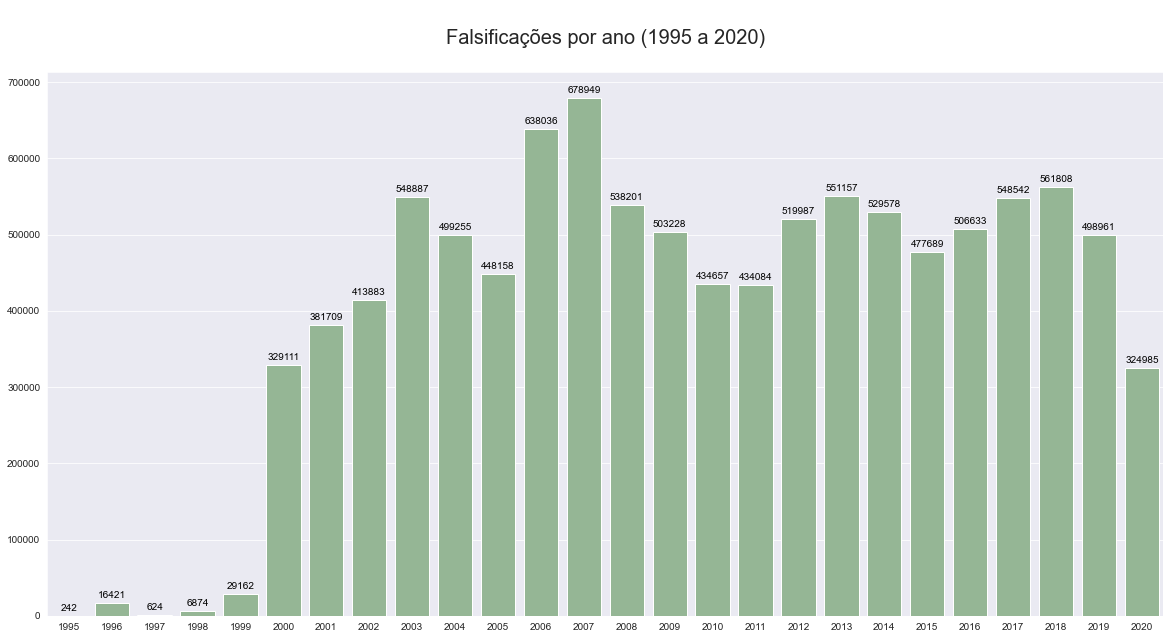

In [74]:
df_temp = df.groupby(['Ano'])['Quantidade'].sum()
df_ano_quantidade = pd.DataFrame(df_temp)
df_ano_quantidade['%'] = df_ano_quantidade['Quantidade'] / df_ano_quantidade['Quantidade'].sum() * 100

print(df_ano_quantidade)

plt.figure(figsize=(20, 10))
plot = sns.barplot(x=df_ano_quantidade.index,
                   y=df_ano_quantidade['Quantidade'],
                   orient='v',
                   palette=['darkseagreen'])
for i in plot.patches:
    plot.annotate(format(i.get_height(), '.0f'),
        (i.get_x() + i.get_width() / 2, i.get_height()),
        ha='center',
        va='baseline',
        fontsize=10,
        color='black',
        xytext=(0, 5),
        textcoords='offset points')
plt.xlabel('')
plt.ylabel('')
plt.title('\nFalsificações por ano (1995 a 2020)\n', fontsize=20)
plt.show(plot)


## 2. Qual o total de falsificações por cédula e por ano (1995 a 2020)?

In [76]:
df_temp = df.groupby(['Ano','Denominação'])['Quantidade'].sum()
df_ano_denominacao_quantidade = pd.DataFrame(df_temp)
#df_ano_denominacao_quantidade['%'] = df_ano_denominacao_quantidade['Quantidade'] / df_ano_denominacao_quantidade['Quantidade'].sum() * 100

print(df_ano_denominacao_quantidade)

#df_ano_denominacao_quantidade.head(10)




                  Quantidade         %
Ano  Denominação                      
1995 50.0                240  0.002303
     100.0                 2  0.000019
1996 5.0                   2  0.000019
     10.0               6088  0.058422
     50.0               8001  0.076779
...                      ...       ...
2020 10.0              17673  0.169593
     20.0              61144  0.586748
     50.0              81277  0.779948
     100.0            154181  1.479548
     200.0              4585  0.043998

[163 rows x 2 columns]


## 3. Qual o total de falsificações por estado no período de 1995 a 2020?

## 4. Quais os 5 estados líderes de falsificações por ano (2015 a 2020)?

## 5. Qual a estimativa do total de falsificações por ano (2021 e 2022)?

## 6. Qual a estimativa do total de falsificações por cédula e por ano (2021 e 2022)?

## 7. Qual a estimativa do total de falsificações por estado no período de 2021 e 2022?